HBox(children=(RadioButtons(description='Speed: ', index=1, options=('Wpm', 'Adjusted-Wpm'), value='Adjusted-Wpm'), RadioButtons(description='Accuracy: ', options=('Total-Error-Rate', 'Uncorrected-Error-Rate', 'Corrected-Error-Rate'), value='Total-Error-Rate')))

ToggleButtons(description='Metric: ', index=5, options=('Speed', 'Accuracy', 'Speed & Accuracy', 'Learning Curve', 'Speed Vs. Accuracy', 'Proof error-correction'), value='Proof error-correction')

HBox(children=(Select(description='Participant: ', options=('All', '#1', '#2', '#3', '#4', '#5', '#6'), value='All'),))

<IPython.core.display.Javascript object>


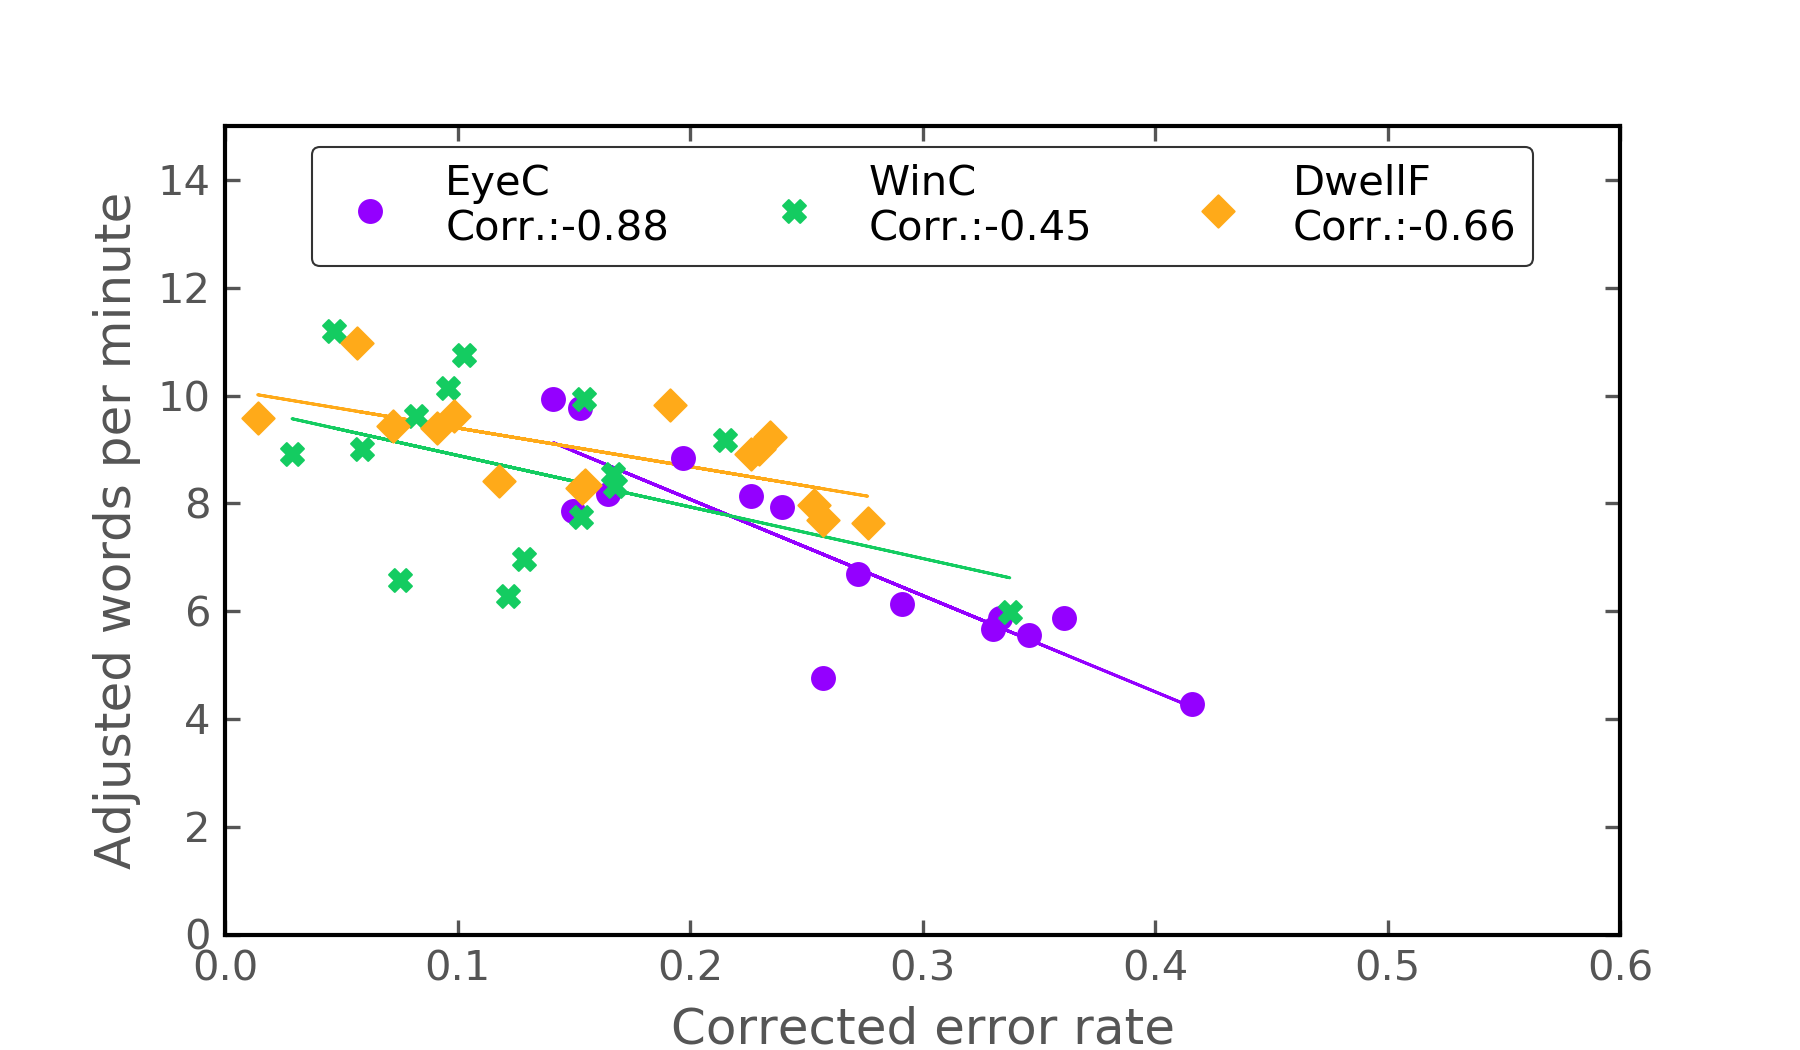

-0.8790872031336235
-0.45406340332603257
-0.6587151045433044


In [21]:
%matplotlib notebook	
import csv
from __future__ import print_function
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np

class Sentence:
	# class variables here
	def __init__(self, participant, sentenceNo, testing):
		# instance variables here
		self.participant = participant
		self.sentenceNo = sentenceNo
		self.testing = testing		# 0: practice; 1: test
		self.keyboard = 0			# 0: win EyeControl; 1: tobii WinControl; 2: tobii Dwell-free
		self.wpm = 0.0
		self.adjWpm = 0.0
		self.totErrRate = 0.0
		self.uncErrRate = 0.0
		self.corErrRate = 0.0
		self.ksps = 0.0
		self.f = 0.0
		self.inputStream = 0.0
		self.speedInProcess = 0.0
		self.seconds = 0.0

def readSentences(argFilename, argSentences):
	with open('Raw-Data/Logs/'+argFilename+'.csv') as csvDataFile:
		csvReader = csv.reader(csvDataFile)
		next(csvReader, None)
		next(csvReader, None)
		for row in csvReader:
			argSentences.append(Sentence(int(argFilename[0])-1, int(row[0]), int(row[1])))
			# exclude exceptions that the test participant didn't enter anything and skipped this sentence			
			if row[3] != 0:			
				sentences[-1].wpm = float(row[3])
				sentences[-1].adjWpm = float(row[4])
				sentences[-1].totErrRate = float(row[11])
				sentences[-1].uncErrRate = float(row[9])
				sentences[-1].corErrRate = float(row[10])				
				sentences[-1].keyboard = ord(argFilename[4])-65
				sentences[-1].ksps = float(row[6])
				sentences[-1].f = float(row[19])	# fixed keystrokes
				sentences[-1].inputStream = float(row[22])	# input stream
				sentences[-1].inputStreamNoF = (float(row[18]))+(float(row[17]))+(float(row[16]))	# C+INF+IF
				sentences[-1].seconds = float(row[2])	# seconds

def clearCache():
	clear_output(wait=True)
	display(widgets.HBox([contrSpeed,contrErrRate]), contrMetric, widgets.HBox([contrPtcp]))
	# clear data storage
	dataStorage = [perPtcpWpm, perPtcpAdjWpm, perPtcpTotErrRate, perPtcpUncErrRate, perPtcpCorErrRate, perPtcpSentenceNo, perPtcpKsps, perPtcpF, perPtcpInputStream, perPtcpInputStreamNoF, perPtcpSeconds]
	for item in dataStorage:
		for index in range(amountPtcp*amountKeyboard):
			del item[index][:]

def onChange_speedOrAccuracy(change):
	if change['type']=='change' and change['name']=='value':
		plotsHub()

def onChange_metric(b):
	if b['type']=='change' and b['name']=='value':
		plotsHub()

def onChange_ptcp(change):
	if change['type']=='change' and change['name']=='value':
		plotsHub()

def plotsHub():
	clearCache()
	# extract sentences according to participant selection
	for item in sentences:
		if item.testing == 1:
			if contrPtcp.value != 'All':
				index = (int(contrPtcp.value[1])-1)*amountKeyboard+item.keyboard
				selectedPtcp = [int(contrPtcp.value[1])-1]
			else:
				# data structure here
				index = item.participant*amountKeyboard+item.keyboard
				selectedPtcp = [i for i in range(amountPtcp)]
			if item.participant in selectedPtcp:
				perPtcpWpm[index].append(item.wpm)
				perPtcpAdjWpm[index].append(item.adjWpm)
				perPtcpTotErrRate[index].append(item.totErrRate)
				perPtcpUncErrRate[index].append(item.uncErrRate)
				perPtcpCorErrRate[index].append(item.corErrRate)
				perPtcpSentenceNo[index].append(item.sentenceNo)
				perPtcpKsps[index].append(item.ksps)
				perPtcpF[index].append(item.f)
				perPtcpInputStream[index].append(item.inputStream)
				perPtcpInputStreamNoF[index].append(item.inputStreamNoF)
				perPtcpSeconds[index].append(item.seconds)
	filter()

	if 'Speed' == contrMetric.value:
		plotSpeed()
	elif 'Accuracy' == contrMetric.value:
		plotAccuracy()
	elif 'Speed & Accuracy' == contrMetric.value:
		plotSpeedNAccuracy()
	elif 'Learning' in contrMetric.value:
		plotLearningCurve()
	elif 'Speed Vs. Accuracy' == contrMetric.value:
		plotSpeedVsAccuracy()
	elif 'Proof error-correction' == contrMetric.value:
		plotProof()

def filter():
	dataStorages = [perPtcpWpm, perPtcpAdjWpm, perPtcpTotErrRate, perPtcpUncErrRate, perPtcpCorErrRate, perPtcpSentenceNo, perPtcpKsps, perPtcpF, perPtcpInputStream]
	for i in range(len(perPtcpAdjWpm)):
		if len(perPtcpAdjWpm[i]):
			mean = np.nanmean(perPtcpAdjWpm[i])
			sd = np.std(perPtcpAdjWpm[i])
			for j in range(len(perPtcpAdjWpm[i])):
				global globalCounter
				globalCounter += 1
				# remove outliers that beyond 2SD from mean
				if (np.absolute(perPtcpAdjWpm[i][j] - mean) >= 2 * sd) or (perPtcpAdjWpm[i][j] <= 0):
					# count how many outliers in the dataset
					global globalOutlierCounter
					globalOutlierCounter += 1
					perPtcpWpm[i][j] = perPtcpAdjWpm[i][j] = perPtcpTotErrRate[i][j] = perPtcpUncErrRate[i][j] = perPtcpCorErrRate[i][j] = perPtcpKsps[i][j] = perPtcpF[i][j] = np.NaN

def plotSpeed():
	with plt.rc_context({'axes.edgecolor':'black', 'axes.facecolor':'white'}):
		fig, ax = plt.subplots(figsize=(2.5,3), dpi=300)
		ax.grid(color='gray', alpha=0.3, axis='y')
		ax.tick_params(axis='both', direction='in', top=True, right=True)		
	ax.set(ylabel='Adjusted words per minute')
	plt.ylim(0,25)
	yWpm = [[] for i in range(amountKeyboard)]
	if contrSpeed.value == 'Wpm':
		plotPerPtcpWpm = perPtcpWpm
	elif contrSpeed.value == 'Adjusted-Wpm':
		plotPerPtcpWpm = perPtcpAdjWpm
	for index in range(len(plotPerPtcpWpm)):
		for subIndex in range(len(plotPerPtcpWpm[index])):
			yWpm[index%amountKeyboard].append(plotPerPtcpWpm[index][subIndex])
	# handle missing data due to data preprocessing
	yWpmMean = []
	for j in range(amountKeyboard):	
		nanIndex = []
		for i in range(len(yWpm[j])):
			if np.isnan(yWpm[j][i]):
				nanIndex.append(i)
		for i in range(len(nanIndex)):
			yWpm[j].pop(nanIndex[i]-i)
	# adjust keyboard order as WinControl, EyeControl, and Dwell-free
	plt.boxplot(yWpm[0], positions=[plotXPosition[1]], showfliers=True, patch_artist=True, 
					boxprops=dict(facecolor=color[0]), medianprops=dict(linewidth=1, linestyle=None, color='white'),widths=0.3)
	plt.boxplot(yWpm[1], positions=[plotXPosition[0]], showfliers=True, patch_artist=True, 
					boxprops=dict(facecolor=color[1]), medianprops=dict(linewidth=1, linestyle=None, color='white'),widths=0.3)
	plt.boxplot(yWpm[2], positions=[plotXPosition[2]], showfliers=True, patch_artist=True, 
					boxprops=dict(facecolor=color[2]), medianprops=dict(linewidth=1, linestyle=None, color='white'),widths=0.3)
	plt.xlim(min(plotXPosition)-1, max(plotXPosition)+1)	
	plt.xticks(plotXPosition, labelKeybd)
	fig.savefig('plotSpeed_'+contrPtcp.value+'.png', bbox_inches='tight')

def plotAccuracy():
	with plt.rc_context({'axes.edgecolor':'black', 'axes.facecolor':'white'}):
		fig, ax = plt.subplots(figsize=(2.5,3), dpi=300)
		ax.grid(color='gray', alpha=0.3, axis='y')
		ax.tick_params(axis='both', direction='in', top=True, right=True)
	ax.set(ylabel='Total error rate')
	plt.ylim(0,1)
	yErrRate = [[] for i in range(amountKeyboard)]
	if contrErrRate.value == 'Total-Error-Rate':
		plotPerPtcpErrRate = perPtcpTotErrRate
	elif contrErrRate.value == 'Uncorrected-Error-Rate':
		plotPerPtcpErrRate = perPtcpUncErrRate
	elif contrErrRate.value == 'Corrected-Error-Rate':
		plotPerPtcpErrRate = perPtcpCorErrRate
	for index in range(len(plotPerPtcpErrRate)):
		for subIndex in range(len(plotPerPtcpErrRate[index])):
			yErrRate[index%amountKeyboard].append(plotPerPtcpErrRate[index][subIndex])
	# handle missing data due to data preprocessing
	yErrorRateMean = []
	for j in range(amountKeyboard):	
		nanIndex = []
		for i in range(len(yErrRate[j])):
			if np.isnan(yErrRate[j][i]):
				nanIndex.append(i)
		for i in range(len(nanIndex)):
			yErrRate[j].pop(nanIndex[i]-i)
	# adjust keyboard order as WinControl, EyeControl, and Dwell-free
	plt.boxplot(yErrRate[0], positions=[plotXPosition[1]], showfliers=True, patch_artist=True, 
					boxprops=dict(facecolor=color[0]), medianprops=dict(linewidth=1, linestyle=None, color='white'),widths=0.3)
	plt.boxplot(yErrRate[1], positions=[plotXPosition[0]], showfliers=True, patch_artist=True, 
					boxprops=dict(facecolor=color[1]), medianprops=dict(linewidth=1, linestyle=None, color='white'),widths=0.3)
	plt.boxplot(yErrRate[2], positions=[plotXPosition[2]], showfliers=True, patch_artist=True, 
					boxprops=dict(facecolor=color[2]), medianprops=dict(linewidth=1, linestyle=None, color='white'),widths=0.3)
	plt.xlim(min(plotXPosition)-1, max(plotXPosition)+1)	
	plt.xticks(plotXPosition, labelKeybd)
	fig.savefig('plotAccuracy_'+contrPtcp.value+'.png', bbox_inches='tight')

def plotSpeedNAccuracy():
	fig, ax = plt.subplots()
	ax.set(title=contrPtcp.value+' participant(s)'+' average typing speed', xlabel='Keyboard', ylabel='AdjWPM')
	plt.ylim(0,15.2)
	yWpm, sdTotErrRate = ([[] for i in range(amountKeyboard)] for j in range(2))
	if contrSpeed.value == 'Wpm':
		plotPerPtcpWpm = perPtcpWpm
	elif contrSpeed.value == 'Adjusted-Wpm':
		plotPerPtcpWpm = perPtcpAdjWpm
	if contrErrRate.value == 'Total-Error-Rate':
		plotPerPtcpErrRate = perPtcpTotErrRate
	elif contrErrRate.value == 'Uncorrected-Error-Rate':
		plotPerPtcpErrRate = perPtcpUncErrRate
	elif contrErrRate.value == 'Corrected-Error-Rate':
		plotPerPtcpErrRate = perPtcpCorErrRate
	for index in range(len(plotPerPtcpWpm)):
		for subIndex in range(len(plotPerPtcpWpm[index])):
			yWpm[index%amountKeyboard].append(plotPerPtcpWpm[index][subIndex])
			sdTotErrRate[index%amountKeyboard].append(plotPerPtcpErrRate[index][subIndex])
	for i in range(amountKeyboard):
		plt.bar(i+1,np.nanmean(yWpm[i]),0.5,color=color[i],label=labelKeybd[i],alpha=0.6)		
	for i in range(amountKeyboard):
		if i == 0:
			eb = plt.errorbar(i+1,np.nanmean(yWpm[i]),np.nanmean(sdTotErrRate[i])*np.nanmean(yWpm[i]),
						color='gray',elinewidth=1,capsize=3,label='Associated error range')
		else:
			eb = plt.errorbar(i+1,np.nanmean(yWpm[i]),np.nanmean(sdTotErrRate[i])*np.nanmean(yWpm[i]),
						color='gray',elinewidth=1,capsize=3)
		eb[-1][0].set_linestyle('--')
	plt.xlim(min(plotXPosition)-1, max(plotXPosition)+1)	
	plt.xticks(plotXPosition, labelKeybd)
	ax.legend(loc='upper left')	
	fig.savefig('plotSpeedNAccuracy_'+contrPtcp.value+'.png', bbox_inches='tight')

def plotLearningCurve():
	# labelLearningCurve = ['EyeControl\nCorr.:0.85', 'WinControl\nCorr.:0.61', 'Dwell-free\nCorr.0.65']
	labelLearningCurve1 = ['EyeC\nTotErrorRate', 'WinC\nTotErrorRate', 'DwellF\nTotErrorRate']
	labelLearningCurve2 = ['UnCorErrorRate', 'UnCorErrorRate', 'UnCorErrorRate']

	with plt.rc_context({'axes.edgecolor':'black', 'axes.facecolor':'white'}):
		fig, ax = plt.subplots(figsize=(6,3.5), dpi=300)
	if contrSpeed.value == 'Wpm':
		plotPerPtcpWpm = perPtcpWpm
	elif contrSpeed.value == 'Adjusted-Wpm':
		plotPerPtcpWpm = perPtcpAdjWpm
	if contrPtcp.value != 'All':
		for index in range(len(plotPerPtcpWpm)):
			if len(plotPerPtcpWpm[index]):
				sdError = [a*b for a,b in zip(plotPerPtcpWpm[index], plotPerPtcpErrRate[index])]
				eb = plt.errorbar(perPtcpSentenceNo[index],plotPerPtcpWpm[index],sdError,
					fmt='.-',color=color[index],elinewidth=6,capsize=3,label=labelKeybd[index],alpha=0.5)
				eb[-1][0].set_linestyle('--')
	else:
		yPerSentenceWpm, yPerSentenceTotErrRate, yPerSentenceUnCorErrRate = ([[([0]*15) for i in range(amountPtcp)] for j in range(amountKeyboard)] for k in range(3))
		tmpPerSentenceNo = [j for j in range(4,19)]
		coefficientsKeybds = []
		for index in range(len(plotPerPtcpWpm)):
			for indexSub in range(len(plotPerPtcpWpm[index])):
				i = tmpPerSentenceNo.index(perPtcpSentenceNo[index][indexSub])
				yPerSentenceWpm[index%amountKeyboard][index//amountKeyboard][i] = plotPerPtcpWpm[index][indexSub]
				yPerSentenceTotErrRate[index%amountKeyboard][index//amountKeyboard][i] = perPtcpTotErrRate[index][indexSub]
				yPerSentenceUnCorErrRate[index%amountKeyboard][index//amountKeyboard][i] = perPtcpUncErrRate[index][indexSub]				
		yWpm, sdTotErrRate, sdUnCorErrorRate = ([([0]*15)for p in range(amountKeyboard)] for q in range(3))
		for i in range(amountKeyboard):
			for j in range(15):
				bufferWpm, bufferErrRate, bufferUnCorErrRate = ([] for q in range(3))
				for k in range(amountPtcp):
					if (yPerSentenceWpm[i][k][j] != 0.0) and (np.isnan(yPerSentenceWpm[i][k][j]) == False):
						bufferWpm.append(yPerSentenceWpm[i][k][j])
						bufferErrRate.append(yPerSentenceTotErrRate[i][k][j])
						bufferUnCorErrRate.append(yPerSentenceUnCorErrRate[i][k][j])						
					else:
						bufferWpm.append(np.NaN)
						bufferErrRate.append(np.NaN)
						bufferUnCorErrRate.append(np.NaN)
				if len(bufferWpm) <= amountPtcp: # threshold = 0.3
					yWpm[i][j] = np.nanmean(bufferWpm)
					sdTotErrRate[i][j] = np.nanmean(bufferErrRate)
					sdUnCorErrorRate[i][j] = np.nanmean(bufferUnCorErrRate)					
				else:
					yWpm[i][j] = 0
					sdTotErrRate[i][j] = 0
					sdUnCorErrorRate[i][j] = 0					
			# data fitting
			x = range(4, 19)
			coefficients = np.polyfit(sdTotErrRate[i], yWpm[i], 1)
			coefficientsKeybds.append(coefficients)
			# plt.plot([q for q in range(4,19)], sdTotErrRate[i], color=color[i], linewidth=1)
			# plt.plot([q for q in range(4,19)], sdUnCorErrorRate[i], '--', color=color[i], linewidth=0.5, alpha=0.3)

		# plt.plot([q for q in range(4,19)], sdTotErrRate[0], marker='.', color=color[0], label=labelLearningCurve1[0], alpha=0.3)
		# plt.plot([q for q in range(4,19)], sdUnCorErrorRate[0], marker='o', color=color[0], label=labelLearningCurve2[0])
		
		# plt.plot([q for q in range(4,19)], sdTotErrRate[1], marker='x', color=color[1], label=labelLearningCurve1[1], alpha=0.3)
		# plt.plot([q for q in range(4,19)], sdUnCorErrorRate[1], marker='X', color=color[1], label=labelLearningCurve2[1])

		# plt.plot([q for q in range(4,19)], sdTotErrRate[2], marker='d', color=color[2], label=labelLearningCurve1[2], alpha=0.3)
		# plt.plot([q for q in range(4,19)], sdUnCorErrorRate[2], marker='D', color=color[2], label=labelLearningCurve2[2])

		plt.plot([q for q in range(4,19)], yWpm[0], marker='o', color=color[0], label=labelKeybd[0])
		plt.plot([q for q in range(4,19)], yWpm[1], marker='X', color=color[1], label=labelKeybd[1])
		plt.plot([q for q in range(4,19)], yWpm[2], marker='D', color=color[2], label=labelKeybd[2])

		for i in range(amountKeyboard):
			xForPlots = sdTotErrRate[i]
			yForPlots = []
			for eachXForPlots in xForPlots:
				yForPlots.append(coefficientsKeybds[i][0]*eachXForPlots + coefficientsKeybds[i][1])
			# plt.plot(xForPlots, yForPlots, color=color[i], linewidth=1)
			# corrcoef = np.corrcoef(yWpm[i], yForPlots)[1,0]
			# print(corrcoef)
	ax.set(xlabel='Sentence #', ylabel='Adjusted words per minute')
	ax.tick_params(axis='both', direction='in', top=True, right=True)
	ax.legend(loc='upper center', facecolor='white', edgecolor='black', ncol=3)
	# ax.grid(color='gray', alpha=0.3, axis='both')
	plt.ylim(0, 15)
	fig.savefig('plotLearningCurve_'+contrPtcp.value+'.png', bbox_inches='tight')

def plotSpeedVsAccuracy():
	with plt.rc_context({'axes.edgecolor':'black', 'axes.facecolor':'white'}):
		fig, ax = plt.subplots(figsize=(6,3.5), dpi=100)
		ax.grid(color='gray', alpha=0.3, axis='y')
		ax.tick_params(axis='both', direction='in', top=True, right=True)
	xSpeed, yErrRate = ([[], [], []] for i in range(2))
	if contrSpeed.value == 'Wpm':
		plotPerPtcpWpm = perPtcpWpm
	elif contrSpeed.value == 'Adjusted-Wpm':
		plotPerPtcpWpm = perPtcpAdjWpm
	if contrErrRate.value == 'Total-Error-Rate':
		plotPerPtcpErrRate = perPtcpTotErrRate
	elif contrErrRate.value == 'Uncorrected-Error-Rate':
		plotPerPtcpErrRate = perPtcpUncErrRate
	elif contrErrRate.value == 'Corrected-Error-Rate':
		plotPerPtcpErrRate = perPtcpCorErrRate
	for index in range(len(plotPerPtcpWpm)):
		if len(plotPerPtcpWpm[index]):
			for indexSub in range(len(plotPerPtcpWpm[index])):
				if (plotPerPtcpWpm[index][indexSub] != 0) and (np.isnan(plotPerPtcpWpm[index][indexSub]) == False):
					xSpeed[index%amountKeyboard].append(plotPerPtcpWpm[index][indexSub])
					yErrRate[index%amountKeyboard].append(plotPerPtcpErrRate[index][indexSub])
	# fig, ax = plt.subplots()
	for i in range(amountKeyboard):
		plt.scatter(yErrRate[i], xSpeed[i], color=color[i], label=labelKeybd[i],s=10)
	ax.legend(loc='upper right', facecolor='white', edgecolor='black')
	# ax.set_xscale('log', basex=2)
	ax.set(xlabel='Corrected error rate', ylabel='Adjusted words per minute')
	plt.xlim(-0.05, 1)
	plt.ylim(0,25)
	fig.savefig('plotWpmVsAccuracy_'+contrPtcp.value+'.png', bbox_inches='tight')

def plotProof():
	labelLearningCurve = ['EyeC\nCorr.:-0.88', 'WinC\nCorr.:-0.45', 'DwellF\nCorr.:-0.66']
	with plt.rc_context({'axes.edgecolor':'black', 'axes.facecolor':'white'}):
		fig, ax = plt.subplots(figsize=(6,3.5), dpi=300)
	if contrPtcp.value == 'All':
		yPerSentenceSpeed, xPerSentenceErrorRate = ([[([0]*15) for i in range(amountPtcp)] for j in range(amountKeyboard)] for k in range(2))
		tmpPerSentenceNo = [j for j in range(4,19)]
		coefficientsKeybds = []
		for index in range(len(perPtcpAdjWpm)):
			for indexSub in range(len(perPtcpAdjWpm[index])):
				i = tmpPerSentenceNo.index(perPtcpSentenceNo[index][indexSub])
				yPerSentenceSpeed[index%amountKeyboard][index//amountKeyboard][i] = perPtcpAdjWpm[index][indexSub]
				xPerSentenceErrorRate[index%amountKeyboard][index//amountKeyboard][i] = perPtcpCorErrRate[index][indexSub]
		ySpeed, xErrorRate = ([([0]*15)for p in range(amountKeyboard)] for q in range(2))
		for i in range(amountKeyboard):
			for j in range(15):
				bufferSpeed, bufferErrorRate = ([] for q in range(2))
				for k in range(amountPtcp):
					if (yPerSentenceSpeed[i][k][j] != 0.0) and (np.isnan(yPerSentenceSpeed[i][k][j]) == False):
						bufferSpeed.append(yPerSentenceSpeed[i][k][j])
						bufferErrorRate.append(xPerSentenceErrorRate[i][k][j])
					else:
						bufferSpeed.append(np.NaN)
						bufferErrorRate.append(np.NaN)
				if len(bufferSpeed) <= amountPtcp: # threshold = 0.3
					ySpeed[i][j] = np.nanmean(bufferSpeed)
					xErrorRate[i][j] = np.nanmean(bufferErrorRate)
				else:
					ySpeed[i][j] = 0
					xErrorRate[i][j] = 0
			# data fitting
			coefficients = np.polyfit(xErrorRate[i], ySpeed[i], 1)
			coefficientsKeybds.append(coefficients)
		for i in range(amountKeyboard):
			xForPlots = xErrorRate[i]
			yForPlots = []
			for eachXForPlots in xForPlots:
				yForPlots.append(coefficientsKeybds[i][0]*eachXForPlots + coefficientsKeybds[i][1])
			plt.plot(xForPlots, yForPlots, color=color[i], linewidth=0.7,zorder=1)
			corrcoef = np.corrcoef(xErrorRate[i], ySpeed[i])[1,0]
			print(corrcoef)
		plt.scatter(xErrorRate[0], ySpeed[0], color=color[0], s=30, label=labelLearningCurve[0],zorder=2)
		plt.scatter(xErrorRate[1], ySpeed[1], color=color[1], s=30, label=labelLearningCurve[1], marker='X',zorder=2)
		plt.scatter(xErrorRate[2], ySpeed[2], color=color[2], s=30, label=labelLearningCurve[2], marker='D',zorder=2)			
	ax.set(xlabel='Corrected error rate', ylabel='Adjusted words per minute')
	ax.tick_params(axis='both', direction='in', top=True, right=True)
	ax.legend(loc='upper center', facecolor='white', edgecolor='black', ncol=3)
	plt.ylim(0,15)
	plt.xlim(0, 0.6)
	fig.savefig('plotProof_'+contrPtcp.value+'.png', bbox_inches='tight')

if __name__=="__main__":
	amountPtcp=6
	amountKeyboard=3
	sentences=[]
	perPtcpWpm, perPtcpAdjWpm, perPtcpTotErrRate, perPtcpUncErrRate, perPtcpCorErrRate, perPtcpSentenceNo, perPtcpKsps, perPtcpF, perPtcpInputStream, perPtcpInputStreamNoF, perPtcpSeconds = ([[] for j in range(amountPtcp*amountKeyboard)] for i in range(11))
	plotXPosition = [1,2,3]
	labelKeybd = ['EyeC', 'WinC', 'DwellF'] * 6
	color = ['#9400FF', '#14CC61','#FFAA19'] * 6 

	filenames = ['2_kbA_logs', '2_kbB_logs', '2_kbC_logs',
				'3_kbA_logs', '3_kbB_logs', '3_kbC_logs',
				'4_kbA_logs', '4_kbB_logs', '4_kbC_logs',
				'5_kbA_logs', '5_kbB_logs', '5_kbC_logs',
				'6_kbA_logs', '6_kbB_logs', '6_kbC_logs']

	for item in filenames:
		readSentences(item, sentences)

	contrSpeed = widgets.RadioButtons(
		options=['Wpm', 'Adjusted-Wpm'],
		description='Speed: ',
		value='Adjusted-Wpm',
		disabled=False
		)
	contrErrRate = widgets.RadioButtons(
		options=['Total-Error-Rate', 'Uncorrected-Error-Rate', 'Corrected-Error-Rate'],
		description='Accuracy: ',
		value='Total-Error-Rate',
		disabled=False
		)
	contrMetric = widgets.ToggleButtons(
		options=['Speed', 'Accuracy', 'Speed & Accuracy', 'Learning Curve', 'Speed Vs. Accuracy', 'Proof error-correction'],
		description='Metric: ',
		value='Accuracy',
		disabled=False
		)
	contrPtcp = widgets.Select(
		options=['All', '#1', '#2', '#3', '#4', '#5', '#6'],
		description='Participant: ',
		value='All',
		disabled=False
		)
	display(widgets.HBox([contrSpeed,contrErrRate]), contrMetric, widgets.HBox([contrPtcp]))
	contrMetric.observe(onChange_metric)
	contrPtcp.observe(onChange_ptcp)
	contrSpeed.observe(onChange_speedOrAccuracy)
	contrErrRate.observe(onChange_speedOrAccuracy)

	globalOutlierCounter = 0
	globalCounter = 0

In [29]:
# Wpm: words per minute regardless its correctness
# Adjusted-Wpm: words per minute regarding corrected input
# Total-Error-Rate: the ratio of error (both corrected and uncorrected) and the whole input stream
# Uncorrected-Error-Rate: the ratio of uncorrected error and the whole input stream
# Corrected-Error-Rate: the ratio of corrected error and the whole input stream

In [37]:
import numpy
tmp = [0.25, 0.05, 0.06, ]
print(numpy.mean(tmp))
print(numpy.std(tmp))

0.32799999999999996
0.068818602136341
